In [98]:
from brainlit.map_neurons.diffeo_gen import expR
from brainlit.map_neurons.map_neurons import Diffeomorphism_Transform
import numpy as np 
import matplotlib.pyplot as plt
import torch
import pickle
import pandas as pd 
import seaborn as sns
import os
from scipy.spatial.distance import cosine


# Create transform

<matplotlib.contour.QuadContourSet object at 0x15b2a8f70>

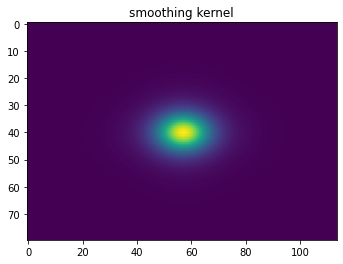

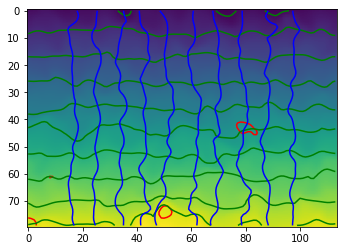

In [92]:
ara_10_size = [1320, 800, 1410]
max_r = 200

# a domain for sampling your velocity and deformatoin
dv = np.array([5.0,5.0,5.0])
nv = np.array([132,80,114])
xv = [np.arange(n)*d - (n-1)*d/2 for n,d in zip(nv,dv)]
levels = np.linspace(-200,200,10)


XV = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xv],indexing='ij'),-1)

# a frequency domain
fv = [np.arange(n)/n/d for n,d in zip(nv,dv)]
FV = np.stack(np.meshgrid(*fv,indexing='ij'),-1)
a = 5.0
p = 2.0
LL = (1.0 - 2.0*a**2*np.sum(((np.cos(2.0*np.pi*FV*dv)   - 1))/dv**2,-1))**(2*p)
K = 1.0/LL
fig,ax = plt.subplots()
ax.imshow(np.fft.ifftshift(K[0]))
ax.set_title('smoothing kernel')


# lets make a new p which is really simple for testing
# sample white noise
Lm = np.random.randn(*FV.shape)*max_r

# smooth it with sqrt(K) (here I smoothed with K to be a bit smoother)
v = np.fft.ifftn(np.fft.fftn(Lm,axes=(0,1,2))*K[...,None],axes=(0,1,2)).real

#shoot it with remannian exponential
phii = expR([torch.tensor(x) for x in xv],torch.tensor(v),K,n=10)

fig,ax = plt.subplots()
ax.imshow(phii[v.shape[0]//2,...,1])
ax.contour(phii[v.shape[0]//2,...,0],levels,colors='r',linestyles='-')
ax.contour(phii[v.shape[0]//2,...,1],levels,colors='g',linestyles='-')
ax.contour(phii[v.shape[0]//2,...,2],levels,colors='b',linestyles='-')

In [36]:
print("each unit is 20 microns")

each unit is 20 microns


# Plot transform

In [37]:
from scipy.spatial.distance import cosine
from brainlit.map_neurons.map_neurons import (
    DiffeomorphismAction,
    Diffeomorphism_Transform,
    transform_geometricgraph,
    compute_derivs,
    CloudReg_Transform,
)
import pandas as pd 
import seaborn as sns
import os 
from cloudvolume import CloudVolume
from pathlib import Path
from brainlit.algorithms.trace_analysis.fit_spline import (
    GeometricGraph,
    compute_parameterization,
    CubicHermiteChain,
)
from brainlit.utils.Neuron_trace import NeuronTrace
from copy import deepcopy
from tqdm import tqdm
from scipy.interpolate import splev, splprep, CubicHermiteSpline
from similaritymeasures import frechet_dist

In [38]:
phii = phii.detach().cpu().numpy()

root_dir = Path(os.path.abspath(""))
data_dir = os.path.join(root_dir, "data", "mapping-files")

In [39]:
ct = Diffeomorphism_Transform(xv, phii)


average squared deformation 5500386.220180694
average 1-cosine between derivatives 0.41250942051890527


<matplotlib.legend.Legend object at 0x159128bb0>

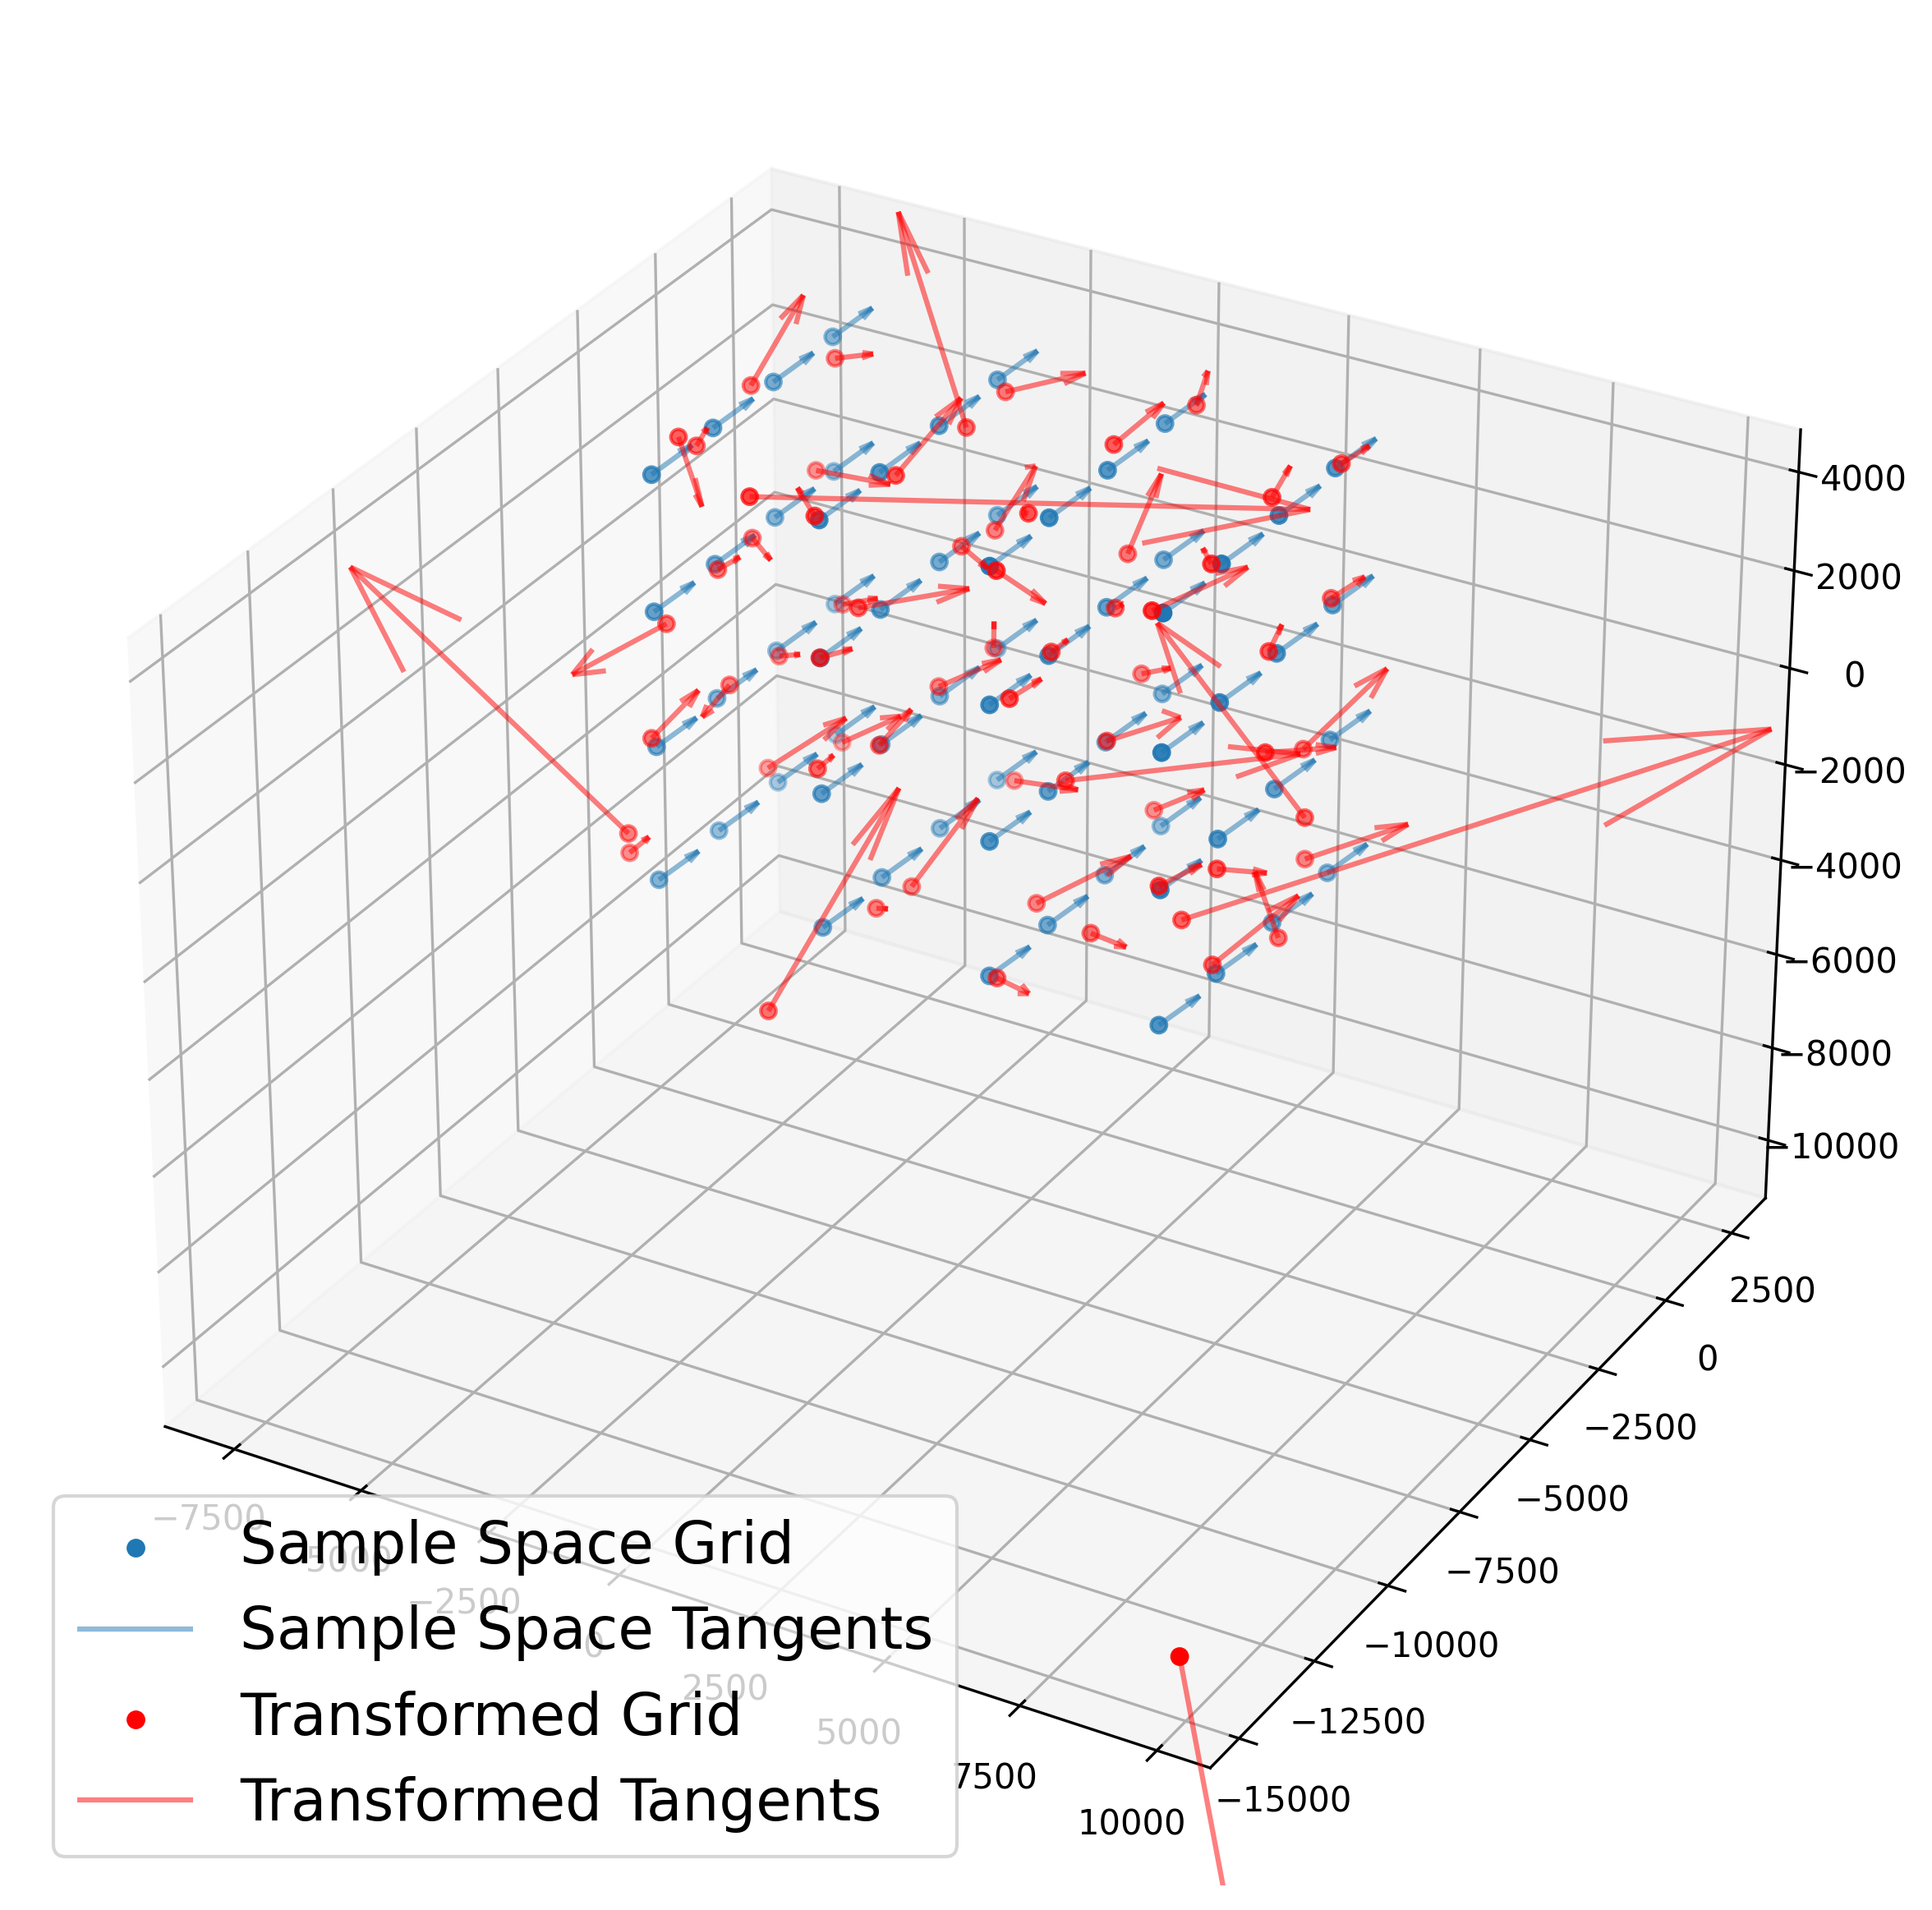

In [40]:
vlen = 500
og_coords = ct.og_coords

xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter3D(
    og_coords[:, 0], og_coords[:, 1], og_coords[:, 2], label="Sample Space Grid"
)

ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    np.ones((og_coords.shape[0])),
    np.ones((og_coords.shape[0])),
    np.ones((og_coords.shape[0])),
    length=vlen,
    label="Sample Space Tangents",
    alpha=0.5,
)

new_coords = ct.evaluate(og_coords)
print(
    f"average squared deformation {np.sum((og_coords-new_coords)**2)/og_coords.shape[0]}"
)
new_derivs = ct.D(og_coords, np.ones(og_coords.shape))
cosines = []
for new_deriv in new_derivs:
    sn = cosine(new_deriv, [1, 1, 1])
    cosines.append(sn)
print(f"average 1-cosine between derivatives {np.mean(cosines)}")

ax.scatter3D(
    new_coords[:, 0],
    new_coords[:, 1],
    new_coords[:, 2],
    label="Transformed Grid",
    color="red",
)
ax.quiver(
    new_coords[:, 0],
    new_coords[:, 1],
    new_coords[:, 2],
    new_derivs[:, 0],
    new_derivs[:, 1],
    new_derivs[:, 2],
    length=vlen,
    color="red",
    label="Transformed Tangents",
    alpha=0.5,
)
# ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], new_coords[:,0]-og_coords[:,0],new_coords[:,1]-og_coords[:,1],new_coords[:,2]-og_coords[:,2], length=20, color='blue', label="Scaled Displacement Field")
ax.legend(fontsize=17)

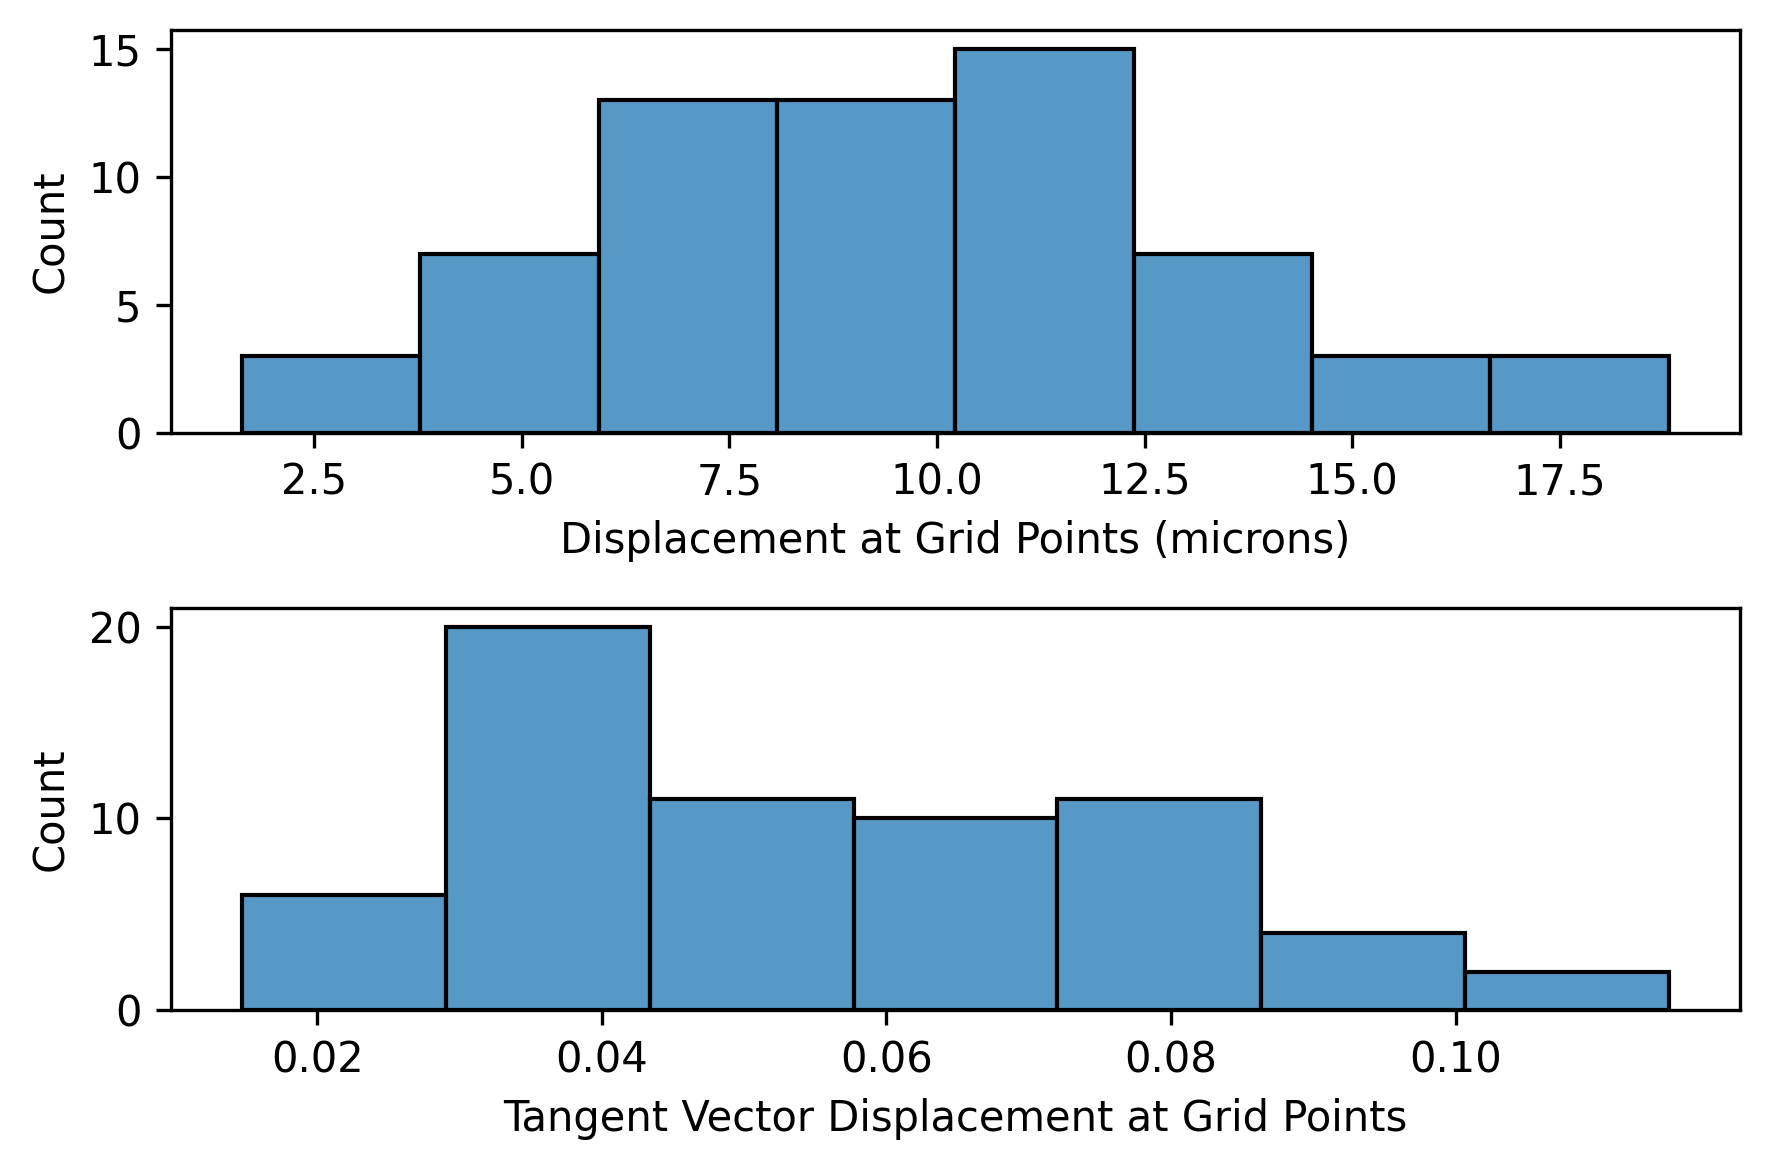

In [9]:
fig, axs = plt.subplots(2, dpi=300)
position_diff = np.linalg.norm(og_coords - new_coords, axis=1)
deriv_diff = np.linalg.norm(np.ones(og_coords.shape) - new_derivs, axis=1)
data = {
    "Displacement at Grid Points (microns)": position_diff,
    "Tangent Vector Displacement at Grid Points": deriv_diff,
}
df = pd.DataFrame(data=data)
sns.histplot(data=df, ax=axs[0], x="Displacement at Grid Points (microns)")
sns.histplot(data=df, ax=axs[1], x="Tangent Vector Displacement at Grid Points")
plt.tight_layout()

In [26]:
ntrace = NeuronTrace("/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/mouselight-swcs/AA1537.swc")
g = ntrace.get_graph()
ds_factor = 1
spacing = 2

coords = []
for n in g.nodes:
    coords.append([g.nodes[n][i] for i in ['x','y','z']])
coords = np.array(coords)
center = np.mean(coords,axis=0)

/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/utils/Neuron_trace.py:741: UserWarning: No offset information found in: /Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/mouselight-swcs/AA1537.swc
  warnings.warn("No offset information found in: " + path)


In [27]:
G_neuron = GeometricGraph()
for n in g.nodes:
    G_neuron.add_node(n, loc = np.array([g.nodes[n][i] for i in ['x','y','z']]) - center)
for e in g.edges:
    G_neuron.add_edge(e[0], e[1])
spline_tree = G_neuron.fit_spline_tree_invariant()

In [28]:
# For each branch
for branch_id in tqdm(
    spline_tree.nodes, desc="Processing branches...", leave=False
):
    # Create geometric graph for the branch
    path = spline_tree.nodes[branch_id]["path"]
    x = []
    y = []
    z = []
    s = []
    p = [-1]

    for point_num, point_id in enumerate(path):
        loc = G_neuron.nodes[point_id]["loc"]
        x.append(loc[0])
        y.append(loc[1])
        z.append(loc[2])
        s.append(point_num)
        if point_num > 0:
            p.append(point_num - 1)

    dict = {"x": x, "y": y, "z": z, "sample": s, "parent": p}
    df = pd.DataFrame(data=dict)
    G_branch = GeometricGraph(df=df, root=s[0])
    G_branch.fit_spline_tree_invariant()
    spline_tree_branch = G_branch.spline_tree

    # downsample
    nodes2keep = [node_i for node_i in range(0, len(s), ds_factor)]
    if s[-1] not in nodes2keep:
        nodes2keep += [s[-1]]
    nodes2remove = [node_i for node_i in s if node_i not in nodes2keep]

    path = spline_tree_branch.nodes[0]["path"]
    tck, us = spline_tree_branch.nodes[0]["spline"]
    positions = np.array(splev(us, tck, der=0)).T

    G_branch_ds = deepcopy(G_branch)
    G_branch_ds.remove_nodes_from(nodes2remove)
    G_branch_ds.remove_edges_from(list(G_branch.edges))
    for node1, node2 in zip(nodes2keep[:-1], nodes2keep[1:]):
        G_branch_ds.add_edge(node1, node2)
    G_branch_ds.fit_spline_tree_invariant(k=1)
    spline_tree_branch_ds = G_branch_ds.spline_tree

    # transform the branch
    G_branch_transformed = deepcopy(G_branch)
    G_branch_ds_transformed = deepcopy(G_branch_ds)
    # G_branch_transformed = transform_geometricgraph(G_branch_transformed, ct, deriv_method="difference")
    G_branch_ds_transformed = transform_geometricgraph(
        G_branch_ds_transformed, ct, deriv_method="two-sided"
    )

    spline_tree_transformed = G_branch_transformed.spline_tree
    spline_tree_transformed_ds = G_branch_ds_transformed.spline_tree

    if len(spline_tree_transformed_ds.nodes) != 1:
        raise ValueError("transformed spline tree does not have 1 branch")

    # Compute sampling length from downsampled branch
    spline = spline_tree_branch_ds.nodes[0]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)
    av_sample_distance = np.mean(np.linalg.norm(np.diff(pts, axis=0), axis=1))

    # Access original knots and compute sample distance
    spline = spline_tree_branch_ds.nodes[0]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)

    # Find dense line points
    tck_line, _ = splprep(pts.T, k=1, s=0, u=u)
    u_dense = np.arange(u[0], u[-1], spacing)
    u_dense = np.append(u_dense, u[-1])
    pts_line = splev(u_dense, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    dense_line_pts = ct.evaluate(pts_line)

    # Find transformed knots
    spline = spline_tree_transformed_ds.nodes[0]["spline"]
    chspline = spline[0]
    u = spline[1]
    u_first_order = np.arange(u[0], u[-1], spacing)
    u_first_order = np.append(u_first_order, u[-1])
    trans_pts = chspline(u)

    # print("0th Order Mapping...")
    u_line = compute_parameterization(trans_pts)
    tck_line, u_line = splprep(trans_pts.T, k=1, s=0, u=u_line)
    u_line = np.arange(u_line[0], u_line[-1], spacing)
    u_line = np.append(u_line, u[-1])
    zero_order_pts = splev(u_line, tck_line)
    zero_order_pts = np.stack(zero_order_pts, axis=1)

    # print("1st order mapping...")
    first_order_pts = chspline(u_first_order)

    for method, method_pts in zip(
        ["Zeroth Order", "First Order"], [zero_order_pts, first_order_pts]
    ):
        error = frechet_dist(dense_line_pts, method_pts)
        print(f"sample: {av_sample_distance}, method {method} error {error}")
        # av_sample_distances.append(av_sample_distance)
        # errors.append(error)
        # methods.append(method)

KeyboardInterrupt: 

Target space: 100%|██████████| 183/183 [00:00<00:00, 127713.42it/s]


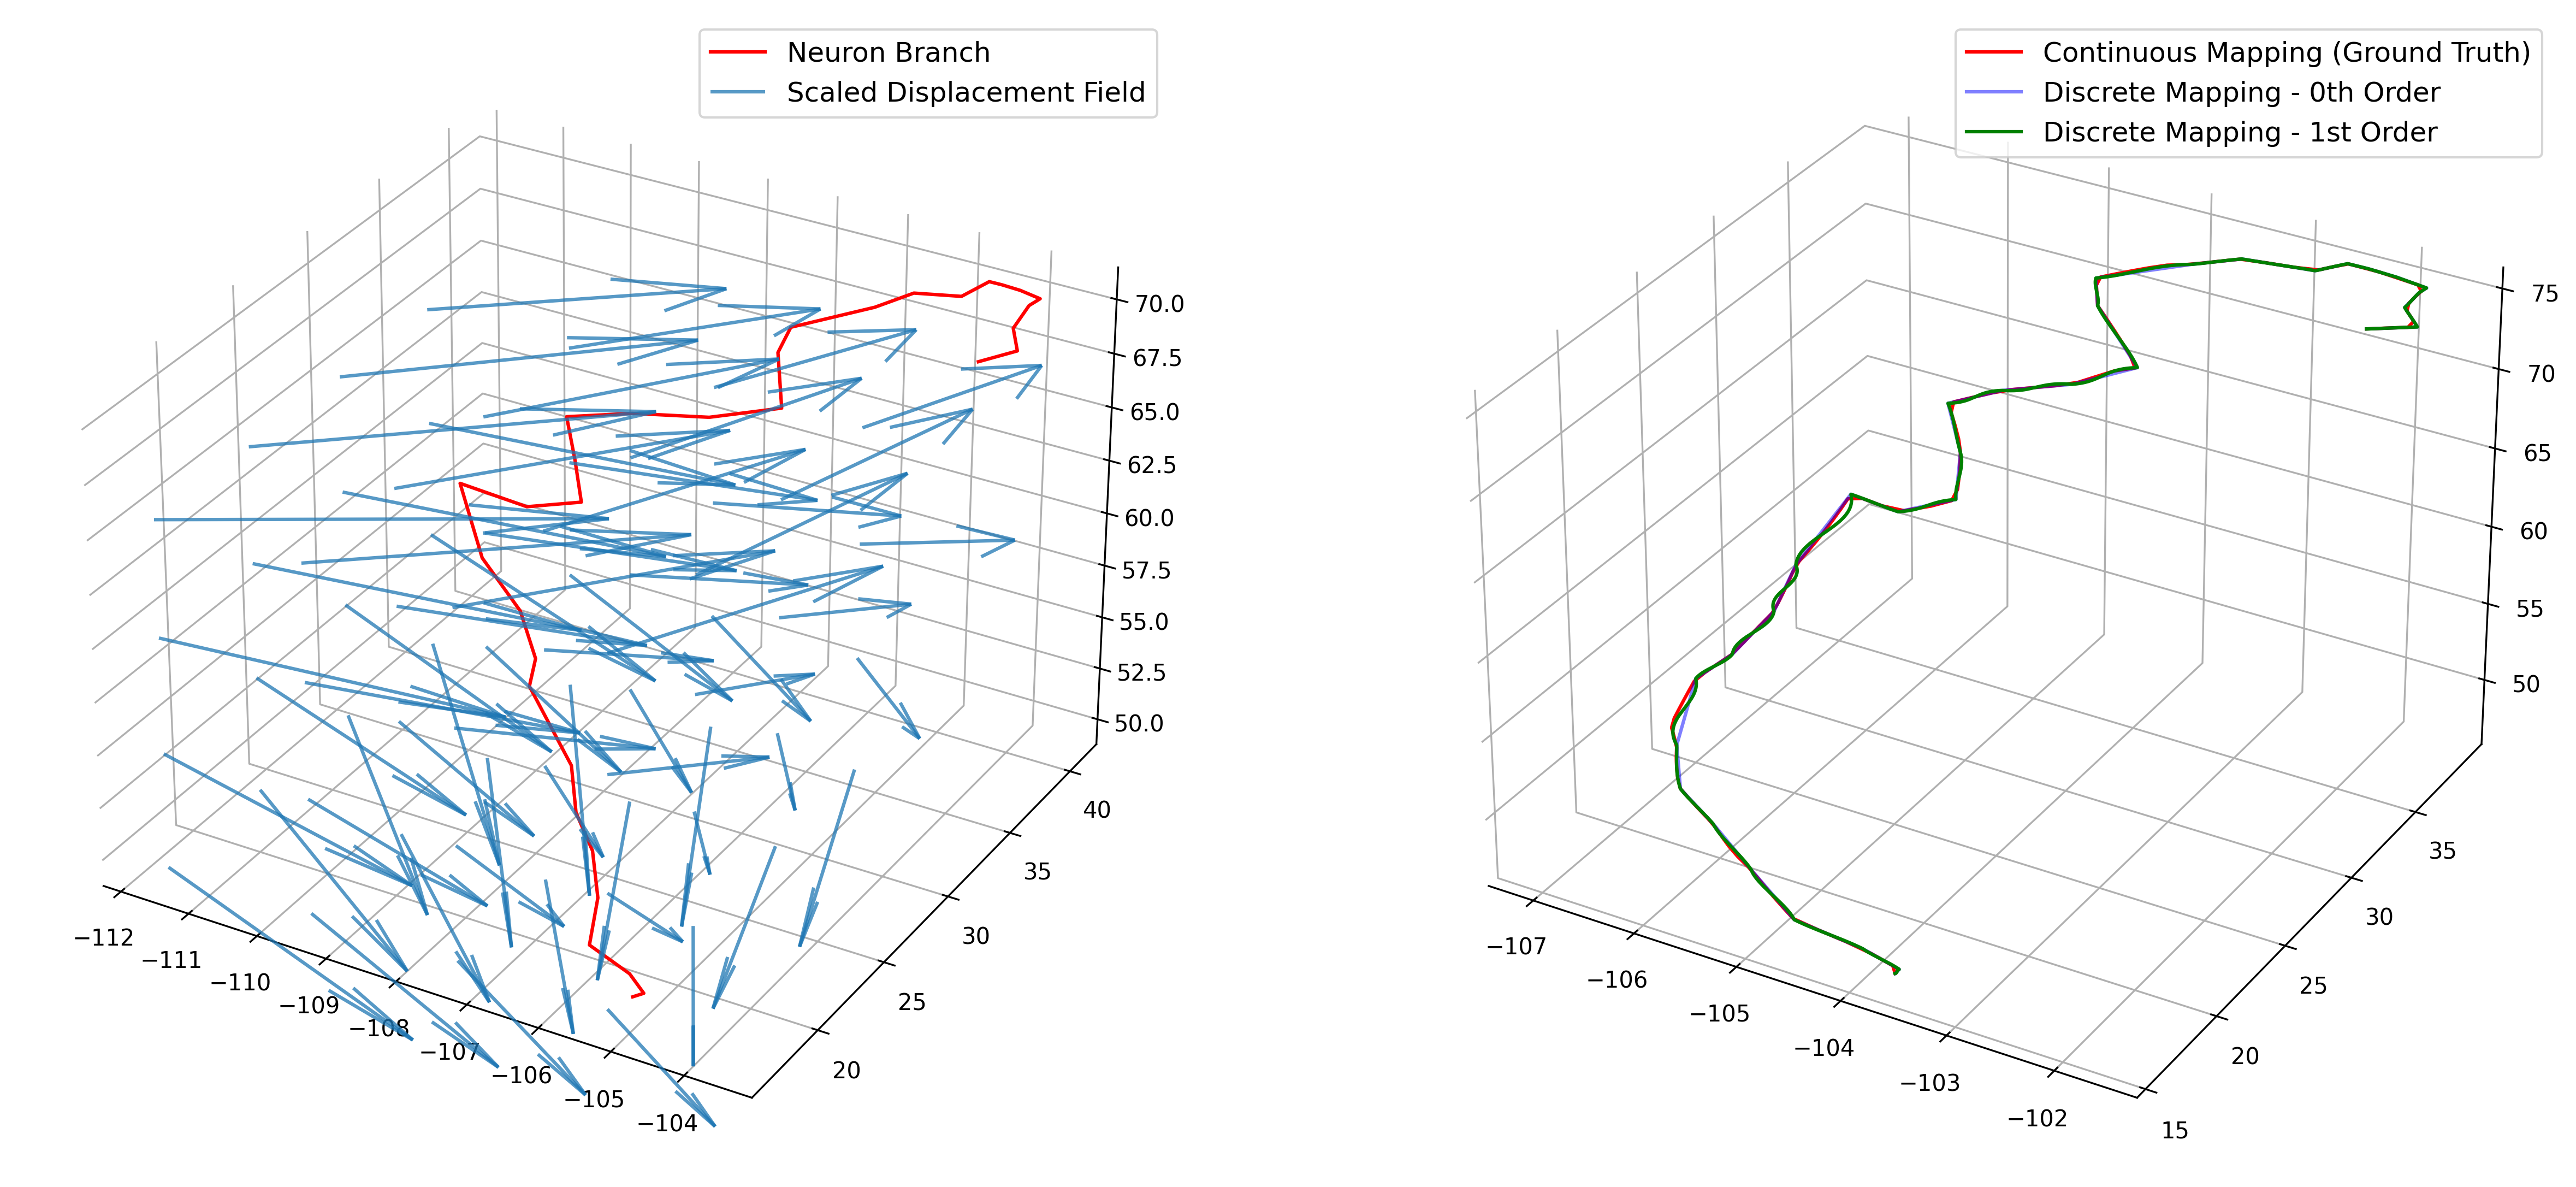

In [37]:
# 1,22; 4,179
neuron_id = 4
branch_id = 179

im_path = "precomputed://file://" + os.path.join(data_dir, "ch1_otsu_iso")
vol_im = CloudVolume(im_path)
shp = np.array(vol_im.shape)
res_im = np.array(vol_im.resolution) / 1000
origin_im = (shp[:3] - 1) * res_im / 2

axons_path = "precomputed://file://" + os.path.join(data_dir, "axons")
vol = CloudVolume(axons_path)
shp = np.array(vol.shape)
res_atlas = np.array(vol.resolution) / 1000
origin_atlas = (shp[:3] - 1) * res_atlas / 2

# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices / 1000 - origin_im

# apply affine transform
coords = (coords - np.mean(coords, axis=0))/20

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
for edge in skel.edges:
    G.add_edge(edge[0], edge[1])

spline_tree = G.fit_spline_tree_invariant()

# Target space

fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 2, 1, projection="3d")

G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, ct, deriv_method="two-sided")
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    if i == 0 or node == branch_id:
        label = "Neuron Branch"
    else:
        label = None
    ax.plot(pts[0], pts[1], pts[2], linestyle="-", label=label, color="red")
    derivs = splev(u, tck, der=1)

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.legend(fontsize=12)


ax = fig.add_subplot(1, 2, 2, projection="3d")

spline = spline_tree.nodes[branch_id]["spline"]
u = spline[1]
tck = spline[0]
pts = splev(u, tck)
pts = np.stack(pts, axis=1)


# dense line points
tck_line, u_line = splprep(pts.T, k=1, s=0)
u_line = np.arange(u_line[0], u_line[-1] + 0.01, 0.01)
pts_line = splev(u_line, tck_line)
pts_line = np.stack(pts_line, axis=1)
trans_pts = ct.evaluate(pts_line)

label = "Continuous Mapping (Ground Truth)"
ax.plot(
    trans_pts[:, 0],
    trans_pts[:, 1],
    trans_pts[:, 2],
    linestyle="-",
    color="red",
    label=label,
)

# Transformed points
trans_pts = ct.evaluate(pts)
label = "Discrete Mapping - 0th Order"
ax.plot(
    trans_pts[:, 0],
    trans_pts[:, 1],
    trans_pts[:, 2],
    linestyle="-",
    label=label,
    color="blue",
    alpha=0.5,
)
derivs = splev(u, tck, der=1)
derivs = np.stack(derivs, axis=1)
trans_derivs = ct.D(pts, derivs)

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree

spline = spline_tree.nodes[branch_id]["spline"]
u = spline[1]
u = np.arange(u[0], u[-1] + 0.01, 0.01)
chspline = spline[0]
pts = chspline(u)

label = "Discrete Mapping - 1st Order"
ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], linestyle="-", label=label, color="green")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)

plt.show()

1st order mappings: 100%|██████████| 257/257 [00:00<00:00, 580.82it/s]


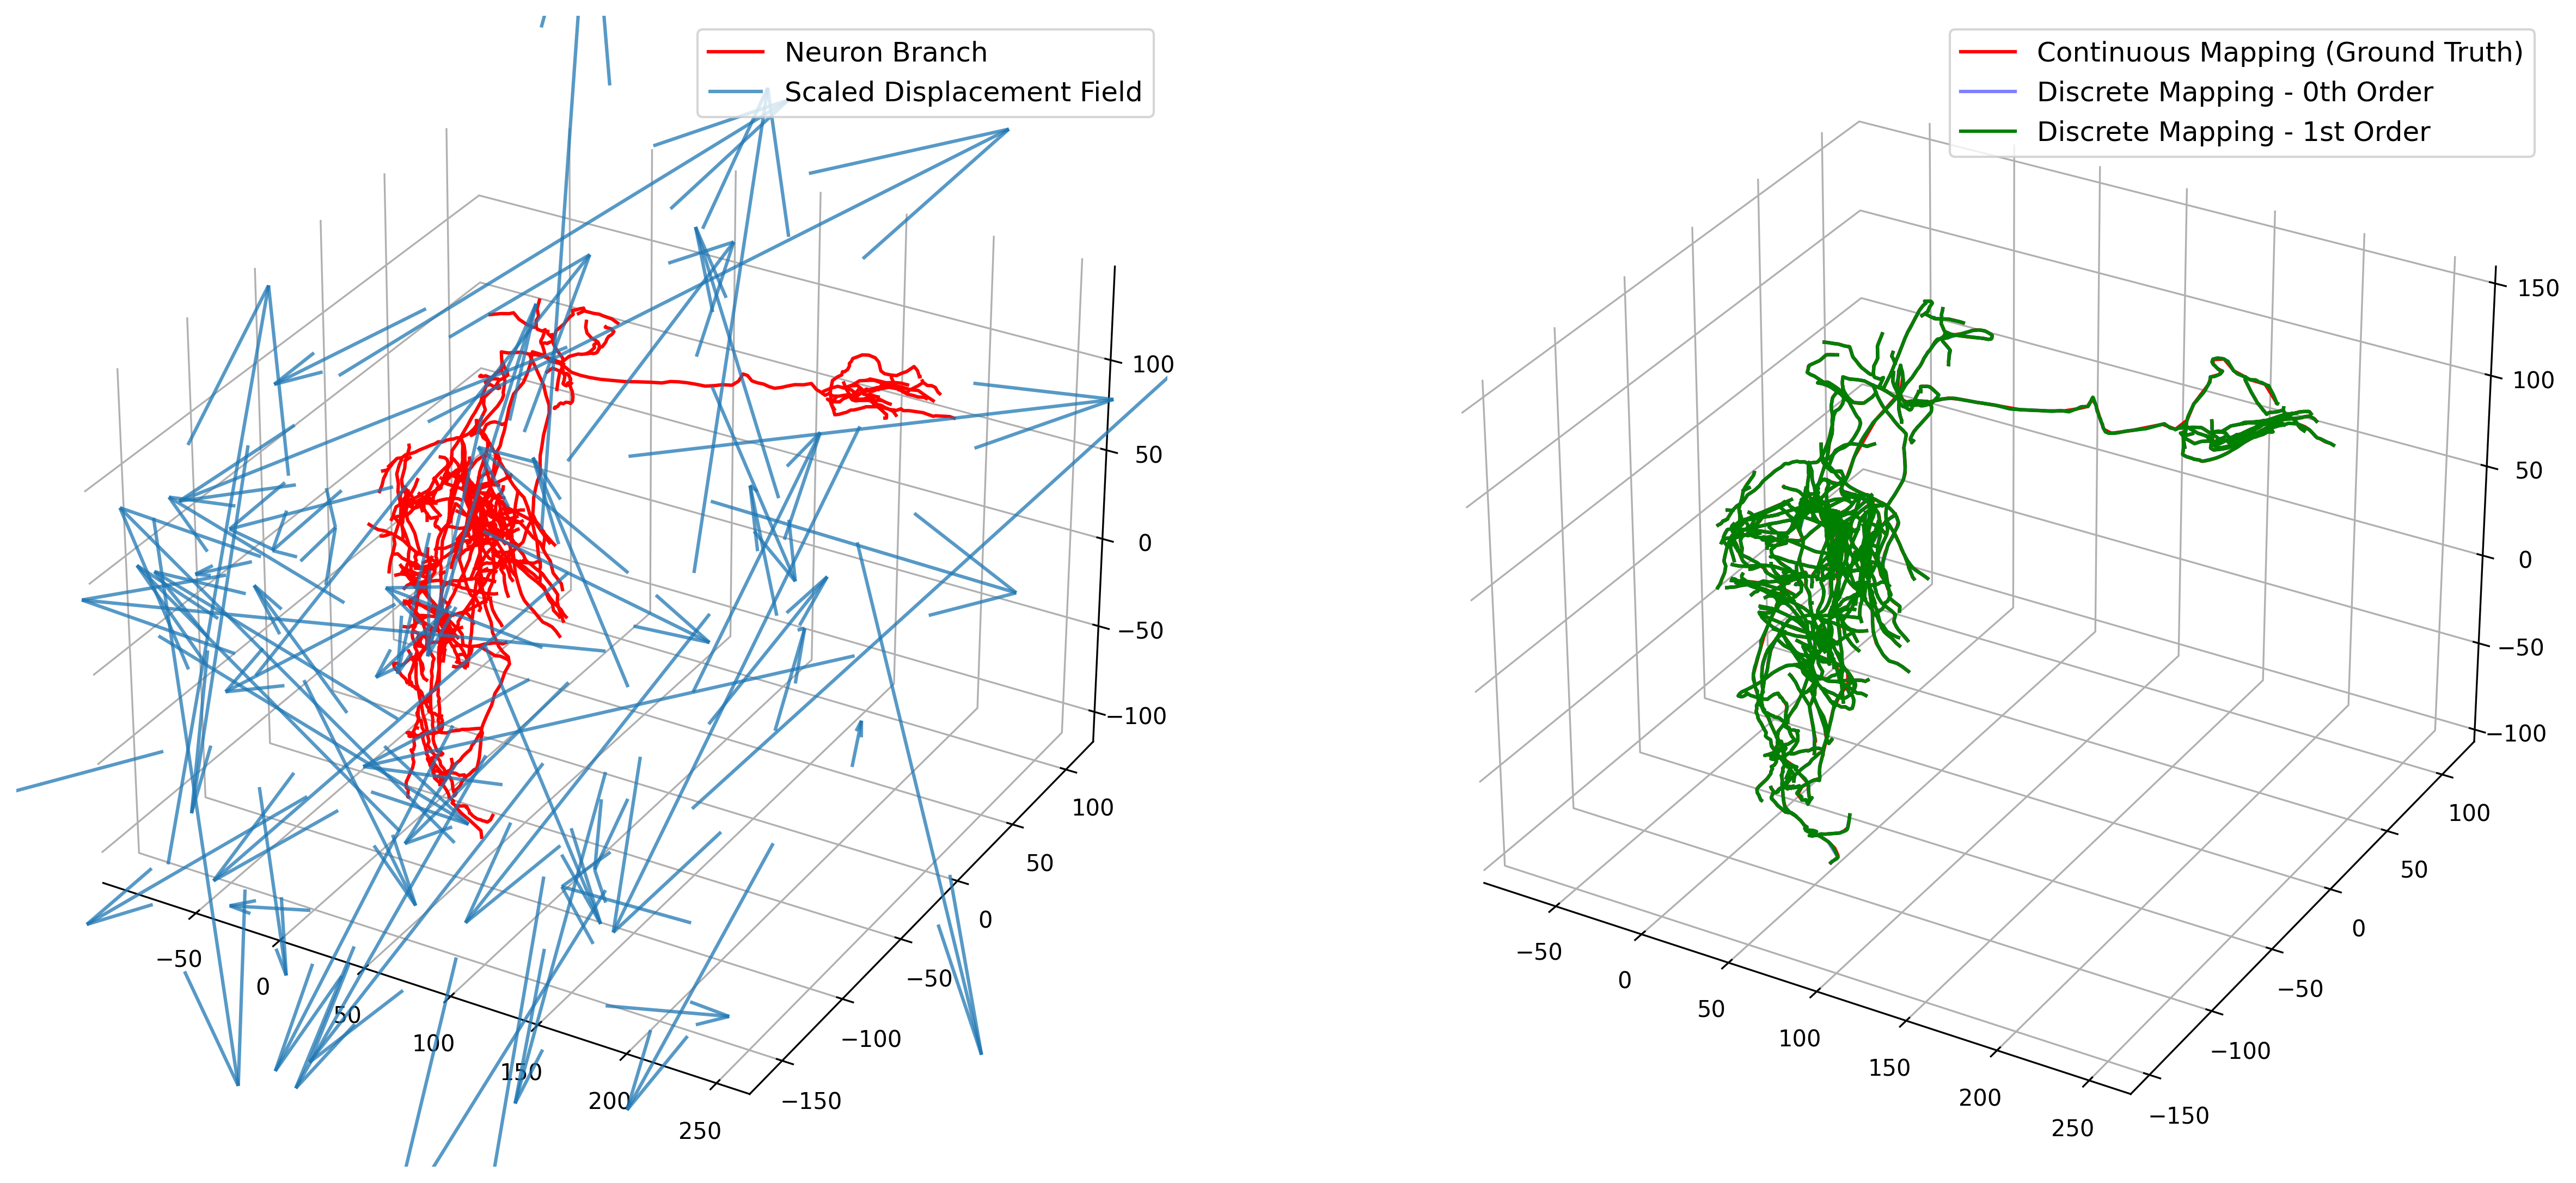

In [46]:
# 1,22; 4,179
neuron_id = 1
branch_id = -1

# get coords in proper cooordinates
skel = vol.skeleton.get(neuron_id)
coords = skel.vertices / 1000 - origin_im

# apply affine transform
coords = (coords - np.mean(coords, axis=0))/10

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
for edge in skel.edges:
    G.add_edge(edge[0], edge[1])

spline_tree = G.fit_spline_tree_invariant()

# Target space

fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 2, 1, projection="3d")

G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, ct, deriv_method="two-sided")
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

for i, node in enumerate(tqdm(spline_tree.nodes, desc="Target space")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]

    # trace points only
    pts = splev(u, tck)
    if i == 0 or node == branch_id:
        label = "Neuron Branch"
    else:
        label = None
    ax.plot(pts[0], pts[1], pts[2], linestyle="-", label=label, color="red")
    derivs = splev(u, tck, der=1)

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.legend(fontsize=12)


ax = fig.add_subplot(1, 2, 2, projection="3d")

for i, node in enumerate(tqdm(spline_tree.nodes, desc="0th order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    tck = spline[0]
    pts = splev(u, tck)
    pts = np.stack(pts, axis=1)

    # dense line points
    tck_line, u_line = splprep(pts.T, k=1, s=0)
    u_line = np.arange(u_line[0], u_line[-1] + 0.01, 0.01)
    pts_line = splev(u_line, tck_line)
    pts_line = np.stack(pts_line, axis=1)
    trans_pts = ct.evaluate(pts_line)
    if i == 0 or node == branch_id:
        label = "Continuous Mapping (Ground Truth)"
    else:
        label = None
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        color="red",
        label=label,
    )

    # Transformed points
    trans_pts = ct.evaluate(pts)
    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 0th Order"
    else:
        label = None
    ax.plot(
        trans_pts[:, 0],
        trans_pts[:, 1],
        trans_pts[:, 2],
        linestyle="-",
        label=label,
        color="blue",
        alpha=0.5,
    )
    derivs = splev(u, tck, der=1)
    derivs = np.stack(derivs, axis=1)
    trans_derivs = ct.D(pts, derivs)

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree
for i, node in enumerate(tqdm(spline_tree.nodes, desc="1st order mappings")):
    if node != branch_id and branch_id != -1:
        continue
    spline = spline_tree.nodes[node]["spline"]
    u = spline[1]
    u = np.arange(u[0], u[-1] + 0.01, 0.01)
    chspline = spline[0]
    pts = chspline(u)

    if i == 0 or node == branch_id:
        label = "Discrete Mapping - 1st Order"
    else:
        label = None
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], linestyle="-", label=label, color="green")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)

plt.show()

In [52]:
import pickle

with open("/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/ds_experiment/random-diffeo.pickle", 'wb') as f:
    pickle.dump(ct, f)

In [51]:
ct

<brainlit.map_neurons.map_neurons.Diffeomorphism_Transform object at 0x1387d3850>

# Plot results

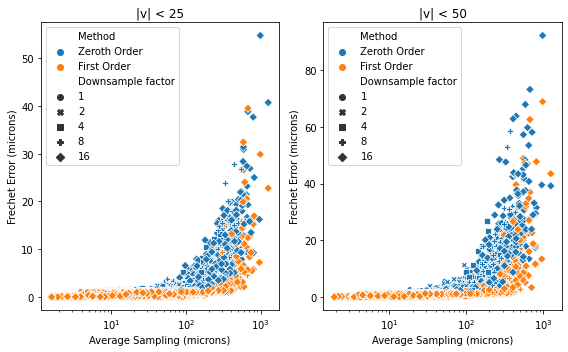

In [108]:
max_rs = [25, 50]
f, axs = plt.subplots(1, len(max_rs))
if len(max_rs) == 1:
    axs = [axs]
f.set_figheight(5)
f.set_figwidth(4*len(max_rs))

dir = "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/ds_experiment/"

for max_r, ax in zip(max_rs,axs):
    files = os.listdir(dir)
    dfs = []
    for file in files:
        if f"maxr{max_r}" in file:
            fname = dir + file
            with open(fname, 'rb') as f:
                data = pickle.load(f)
                dfs.append(pd.DataFrame(data = data))

    df = pd.concat(dfs)

    sns.scatterplot(data = df, x = "Average Sampling (microns)", y="Frechet Error (microns)", hue="Method", style = "Downsample factor", ax=ax)
    ax.title.set_text(f'|v| < {max_r}')
    ax.set_xscale('log')
plt.tight_layout()

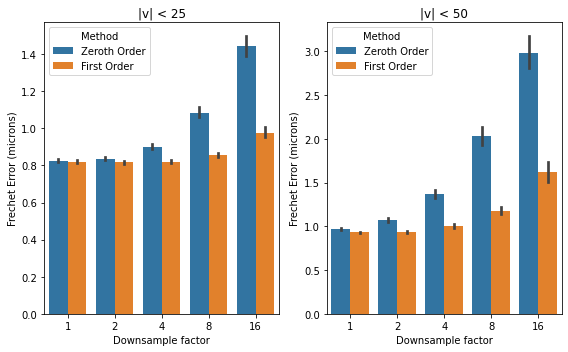

In [109]:
max_rs = [25, 50]
f, axs = plt.subplots(1, len(max_rs))
if len(max_rs) == 1:
    axs = [axs]
f.set_figheight(5)
f.set_figwidth(4*len(max_rs))

dir = "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/ds_experiment/"

for max_r, ax in zip(max_rs,axs):
    files = os.listdir(dir)
    dfs = []
    for file in files:
        if f"maxr{max_r}" in file:
            fname = dir + file
            with open(fname, 'rb') as f:
                data = pickle.load(f)
                dfs.append(pd.DataFrame(data = data))

    df = pd.concat(dfs)

    sns.barplot(data = df, x = "Downsample factor", y="Frechet Error (microns)", hue="Method", ax=ax)
    ax.title.set_text(f'|v| < {max_r}')
    
plt.tight_layout()

In [110]:
max_r = 50
fname = f"/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/ds_experiment/{max_r}.pickle"

with open(fname, 'rb') as f:
    data = pickle.load(f)
xv = data["xv"]
phii = data["phii"]

ct = Diffeomorphism_Transform(xv, phii)

average squared deformation 2863.1733273189093
average 1-cosine between derivatives 0.007864738567484866


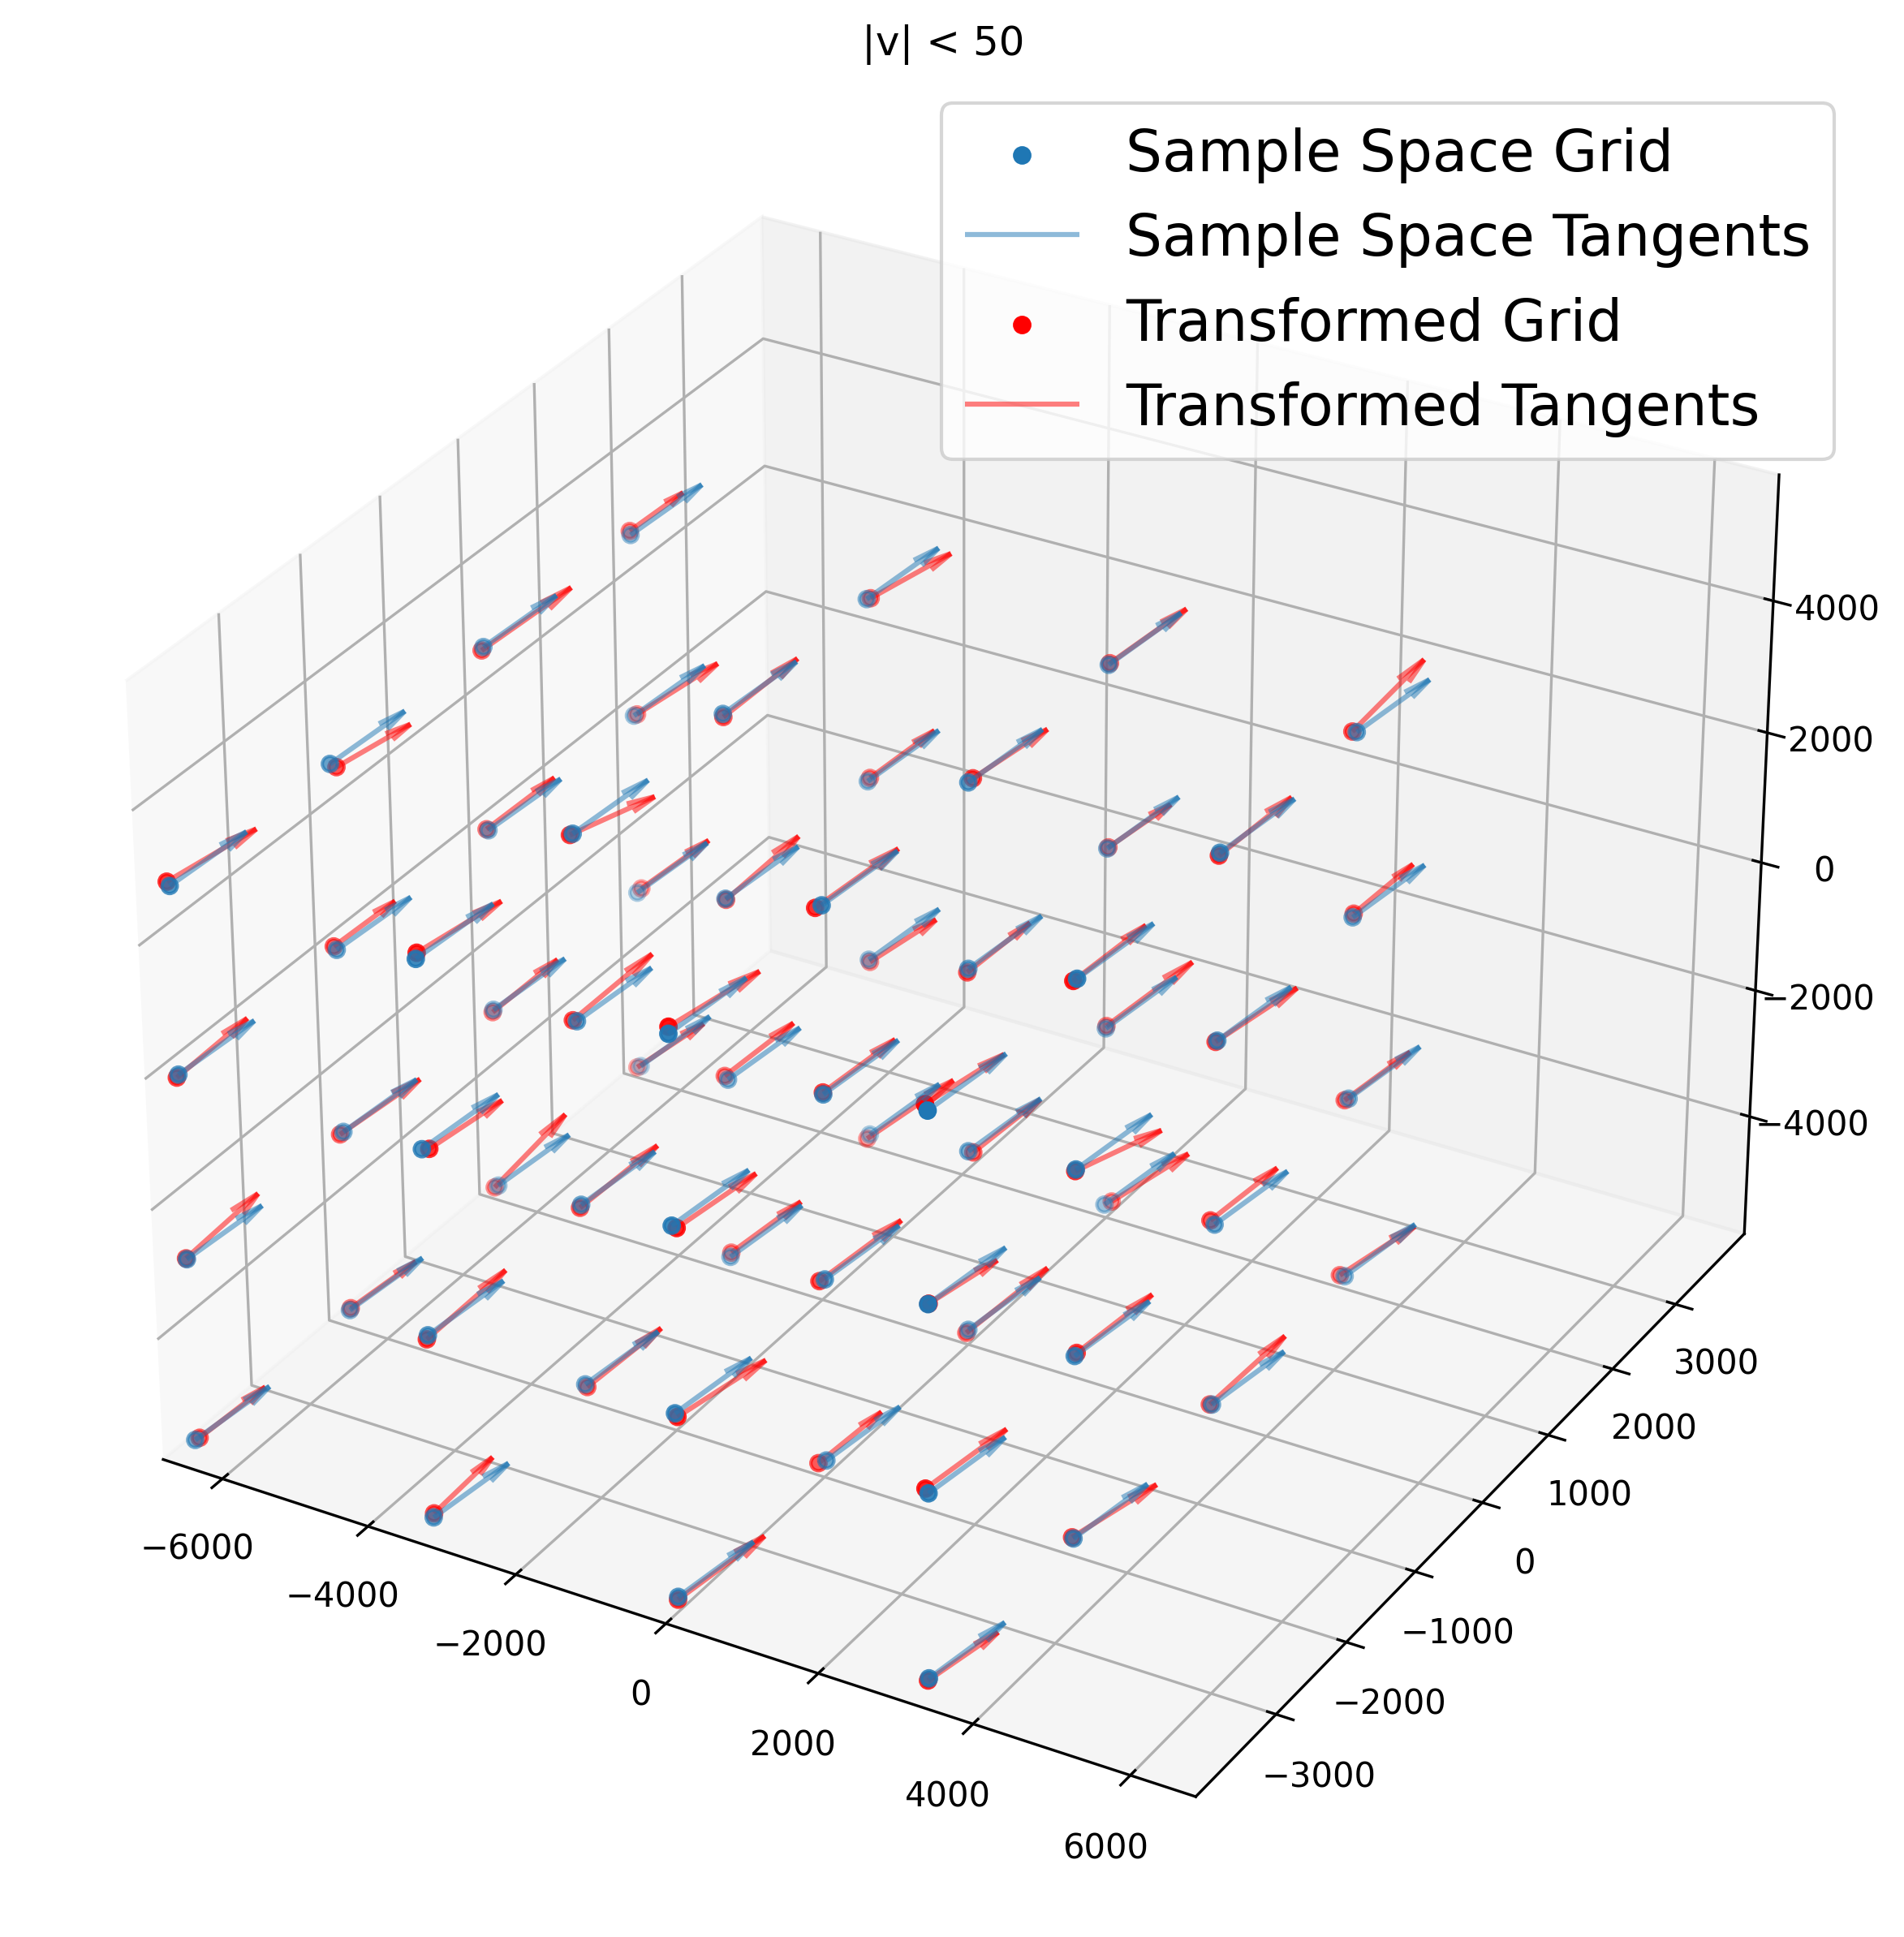

In [111]:
vlen = 500
og_coords = ct.og_coords

xmin = np.amin(og_coords[0])
xmax = np.amax(og_coords[0])
ymin = np.amin(og_coords[1])
ymax = np.amax(og_coords[1])
zmin = np.amin(og_coords[2])
zmax = np.amax(og_coords[2])

xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T

fig = plt.figure(figsize=(10, 10), dpi=300)
ax = fig.add_subplot(projection='3d')

ax.scatter3D(
    og_coords[:, 0], og_coords[:, 1], og_coords[:, 2], label="Sample Space Grid"
)

ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    np.ones((og_coords.shape[0])),
    np.ones((og_coords.shape[0])),
    np.ones((og_coords.shape[0])),
    length=vlen,
    label="Sample Space Tangents",
    alpha=0.5,
)

new_coords = ct.evaluate(og_coords)
print(
    f"average squared deformation {np.sum((og_coords-new_coords)**2)/og_coords.shape[0]}"
)
new_derivs = ct.D(og_coords, np.ones(og_coords.shape))
cosines = []
for new_deriv in new_derivs:
    sn = cosine(new_deriv, [1, 1, 1])
    cosines.append(sn)
print(f"average 1-cosine between derivatives {np.mean(cosines)}")

ax.scatter3D(
    new_coords[:, 0],
    new_coords[:, 1],
    new_coords[:, 2],
    label="Transformed Grid",
    color="red",
)
ax.quiver(
    new_coords[:, 0],
    new_coords[:, 1],
    new_coords[:, 2],
    new_derivs[:, 0],
    new_derivs[:, 1],
    new_derivs[:, 2],
    length=vlen,
    color="red",
    label="Transformed Tangents",
    alpha=0.5,
)
# # ax.quiver(og_coords[:,0],og_coords[:,1],og_coords[:,2], new_coords[:,0]-og_coords[:,0],new_coords[:,1]-og_coords[:,1],new_coords[:,2]-og_coords[:,2], length=20, color='blue', label="Scaled Displacement Field")
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_zlim([zmin, zmax])
ax.legend(fontsize=17)
ax.title.set_text(f"|v| < {max_r}")